# Scraping Tbilisi Apartments Data from https://ss.ge/ka/udzravi-qoneba 

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pickle
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plt.style.use('ggplot')

data_dicts=[]

for page in range(1,4001):
    page_url=f'https://ss.ge/ka/udzravi-qoneba/l/bina/iyideba?Page={page}&RealEstateTypeId=5&RealEstateDealTypeId=4&MunicipalityId=95&CityIdList=95&PrcSource=1&PriceType=false&CurrencyId=1'
    soup=BeautifulSoup(requests.get(page_url).content,'html.parser')

    for i,div in enumerate(soup.select('div[class="latest_article_each_in"]'),start=1):
        title=div.select_one('span[class="TiTleSpanList"]')
        location=div.select_one('div[class="StreeTaddressList"]')
        price=div.select_one('div[class="latest_price"]')
        area=div.select_one('div[class="latest_flat_km"]')
        flat_type=div.select_one('div[class="latest_flat_type"]')
        floor=div.select_one('div[class="latest_stair_count"]')
        time=div.select_one('div[class="add_time"]')
        description=div.select_one('div[class="DescripTionListB"]')
        
        title=title.text.replace('\n','').replace('\r','').strip() if title else None
        location=location.text.replace('\n','').replace('\r','').strip() if location else None
        price=price.text.replace('\n','').replace('\r','').strip() if price else None
        area=area.text.replace('\n','').replace('\r','').replace(' ','').strip() if area else None
        flat_type=flat_type.text.replace('\n','').replace('\r','').strip() if flat_type else None
        floor=floor.text.replace('\n','').replace('\r','').replace(' ','').strip() if floor else None
        time=time.text.replace('\n','').replace('\r','').strip() if time else None
        description=description.text.replace('\n','').replace('\r','').strip() if description else None
        article_id=f'{page}-{i}'

        data_dicts.append({
            'ArticleID':article_id,
            'Title':title,
            'Location':location,
            'Price':price,
            'Area':area,
            'Type':flat_type,
            'Floor':floor,
            'Time':time,
            'Description':description
        })
    print(f'{page} pages scareped')
    if page%100==0:
        pickle.dump(data_dicts,open(f'ss{page-100}-{page}.pickle','wb'))
        data_dicts=[]

# Cleaning Data 

In [2]:
data=[]
for file in os.listdir():
    if file.endswith('pickle'):
        pickle_file=pickle.load(open(file,'rb'))
        data=data+pickle_file
        
df=pd.DataFrame(data)

In [3]:
df.sample()

,ArticleID,Title,Location,Price,Area,Type,Floor,Time,Description
42694,3140-15,იყიდება 5 ოთახიანი ბინა დიდ დიღომში,მირიან მეფის ქ.,311 000 U,180m²,ახალი აშენებული,13სართ.,04.04.2023 / 12:07,იყიდება ბინა მირიან მეფის ქუჩაზე.rnბინა არის პ...


In [4]:
df['ArticleID']=[i for i in range(len(df['ArticleID']))]

In [5]:
df['Price']=pd.to_numeric(df['Price'].str.replace(' ','').str.replace('U',''),errors='coerce')

In [6]:
df['Area']=pd.to_numeric(df['Area'].str.replace('m²',''),errors='coerce')

In [7]:
df['Floor']=pd.to_numeric(df['Floor'].str.replace('სართ.',''),errors='coerce')

C:\Users\berid\AppData\Local\Temp\ipykernel_11632\664834581.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Floor']=pd.to_numeric(df['Floor'].str.replace('სართ.',''),errors='coerce')


In [8]:
df['Suburb']=df['Title'].apply(lambda x:x.split('ბინა')[-1].strip())

In [9]:
df['Rooms']=df['Title'].apply(lambda x:x.split('იყიდება ')[-1].split(' ')[0].strip())

In [10]:
# can't use pd.to_datetime for some unexplained reason

df['Day']=df['Time'].apply(lambda x:int(x.split('.')[0]))
df['Month']=df['Time'].apply(lambda x:int(x.split('.')[1].strip().replace('0','')))
df['Year']=df['Time'].apply(lambda x:int(x.split('.')[2].split('/')[0].strip()))

df['Time']=pd.to_datetime(df.apply(lambda x:f"{x['Year']}-{x['Month']}-{x['Day']}",axis=1))
df=df.drop(columns=['Day','Month','Year','Title'])

In [11]:
df=df.sort_values('Time',ascending=False)

In [12]:
df['PriceSQMT']=df['Price']/df['Area']

In [13]:
df=df.rename(columns={'Price':'Price (GEL)','PriceSQMT':'PriceSQMT (GEL)','Time':'Date','Location':'Street','Area':'Area (SQM)'})

In [14]:
df=df[df['PriceSQMT (GEL)']<2*10**4]

In [15]:
df=df[['ArticleID','Date','Suburb','Street','Type','Area (SQM)','Rooms','Floor','Price (GEL)','PriceSQMT (GEL)','Description']]

In [16]:
#df.to_csv('csv_files//Tbilisi_Apartment_Housing.csv',index=False,encoding='utf-8') # save dataframe as a CSV file

# Analyzing Data 

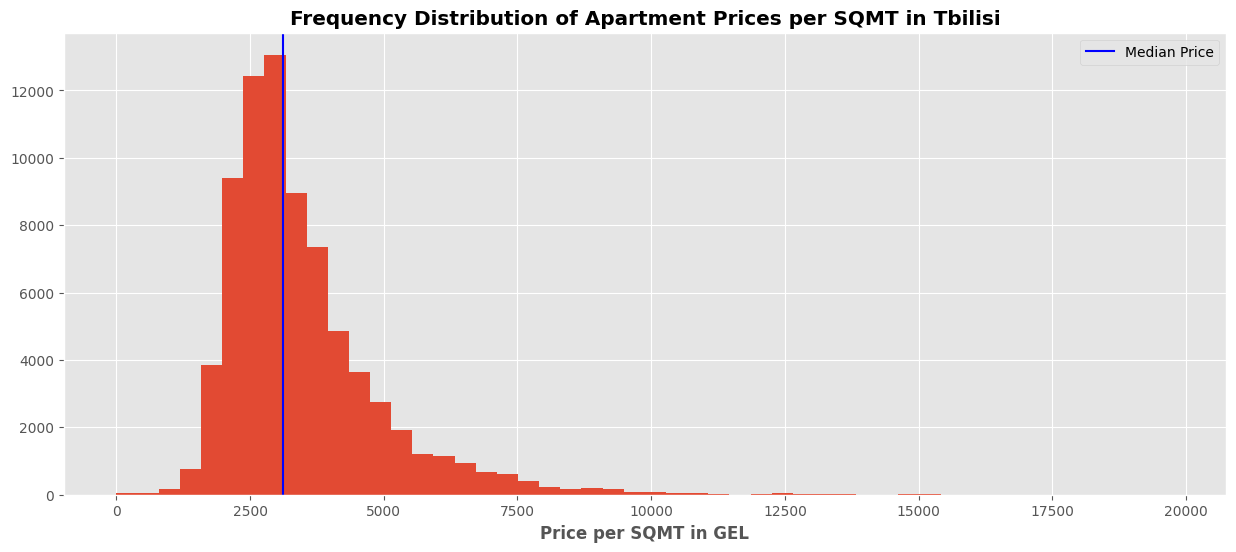

In [17]:
fig,ax=plt.subplots(figsize=(15,6))
df['PriceSQMT (GEL)'].hist(ax=ax,bins=50)
ax.axvline(df['PriceSQMT (GEL)'].median(),label='Median Price',color='blue')
ax.set_title('Frequency Distribution of Apartment Prices per SQMT in Tbilisi',fontweight='bold')
ax.set_xlabel('Price per SQMT in GEL',fontweight='bold')
plt.legend()
plt.show()

In [18]:
df['Week']=df['Date'].dt.to_period('W').astype('str')

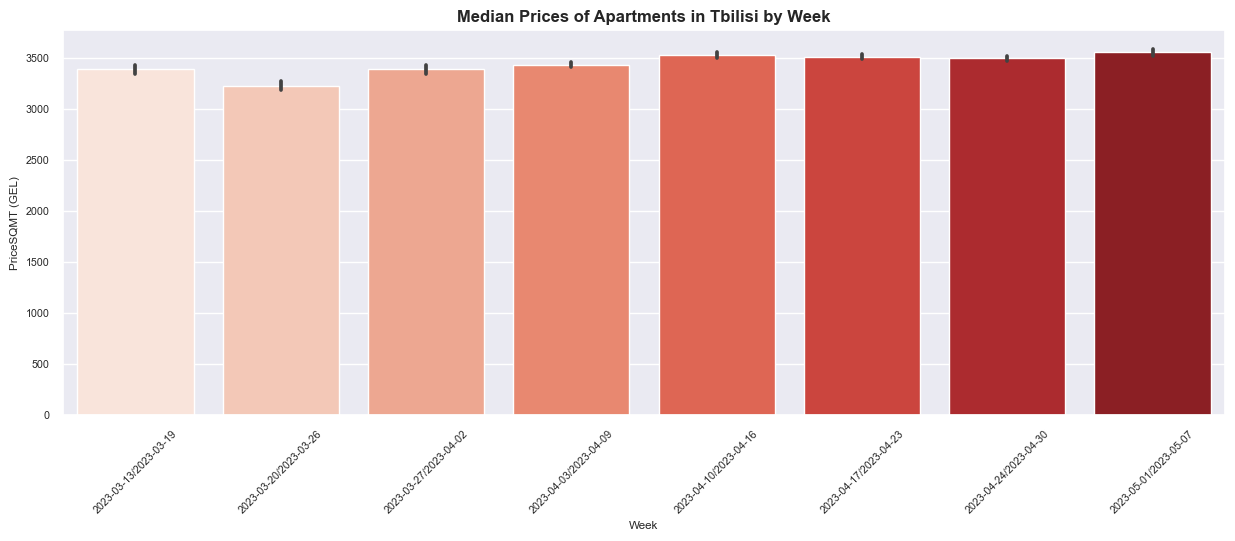

In [19]:
sns.set(font_scale=0.7)
plt.figure(figsize=(15,5))
sns.barplot(df.sort_values('Week'),x='Week',y='PriceSQMT (GEL)',palette='Reds')
plt.title('Median Prices of Apartments in Tbilisi by Week',size=12,fontweight='bold')
plt.xticks(rotation=45)
#plt.ylim(1000,5000)
plt.show()

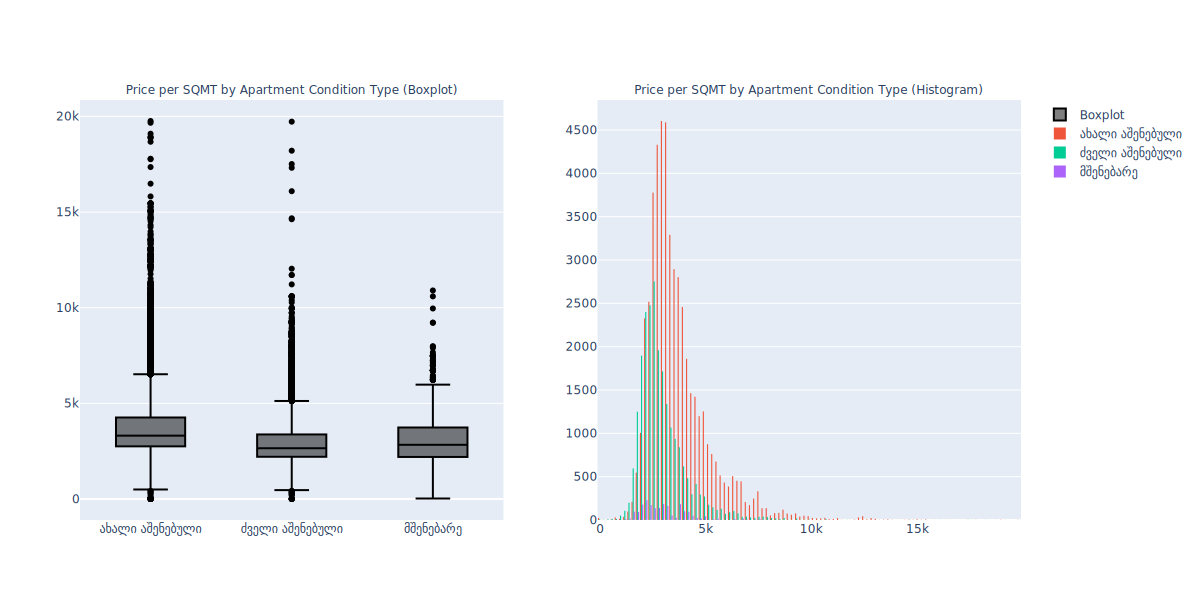

In [20]:
fig=make_subplots(rows=1,cols=2,
                 subplot_titles=['Price per SQMT by Apartment Condition Type (Boxplot)','Price per SQMT by Apartment Condition Type (Histogram)'])

trace1=go.Box(name='Boxplot',x=df['Type'],y=df['PriceSQMT (GEL)'],marker_color='black')
trace21=go.Histogram(name='ახალი აშენებული',x=df.query('Type=="ახალი აშენებული"')['PriceSQMT (GEL)'],xbins=dict(size=df.query('Type=="ახალი აშენებული"')['PriceSQMT (GEL)'].max()/100))
trace22=go.Histogram(name='ძველი აშენებული',x=df.query('Type=="ძველი აშენებული"')['PriceSQMT (GEL)'],xbins=dict(size=df.query('Type=="ძველი აშენებული"')['PriceSQMT (GEL)'].max()/100))
trace23=go.Histogram(name='მშენებარე',x=df.query('Type=="მშენებარე"')['PriceSQMT (GEL)'],xbins=dict(size=df.query('Type=="მშენებარე"')['PriceSQMT (GEL)'].max()/100))


fig.add_trace(trace1,row=1,col=1)
fig.add_trace(trace21,row=1,col=2)
fig.add_trace(trace22,row=1,col=2)
fig.add_trace(trace23,row=1,col=2)

fig.update_annotations(font_size=12,font_family='Arial Black')
fig.update_layout(height=600,width=1200)

fig.show('svg')

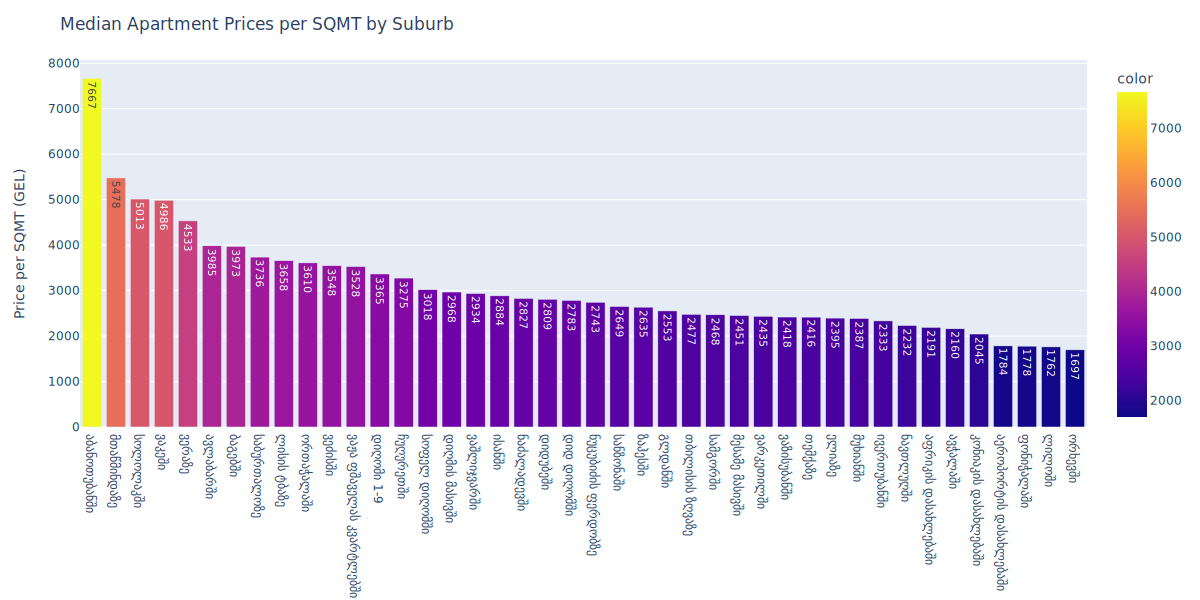

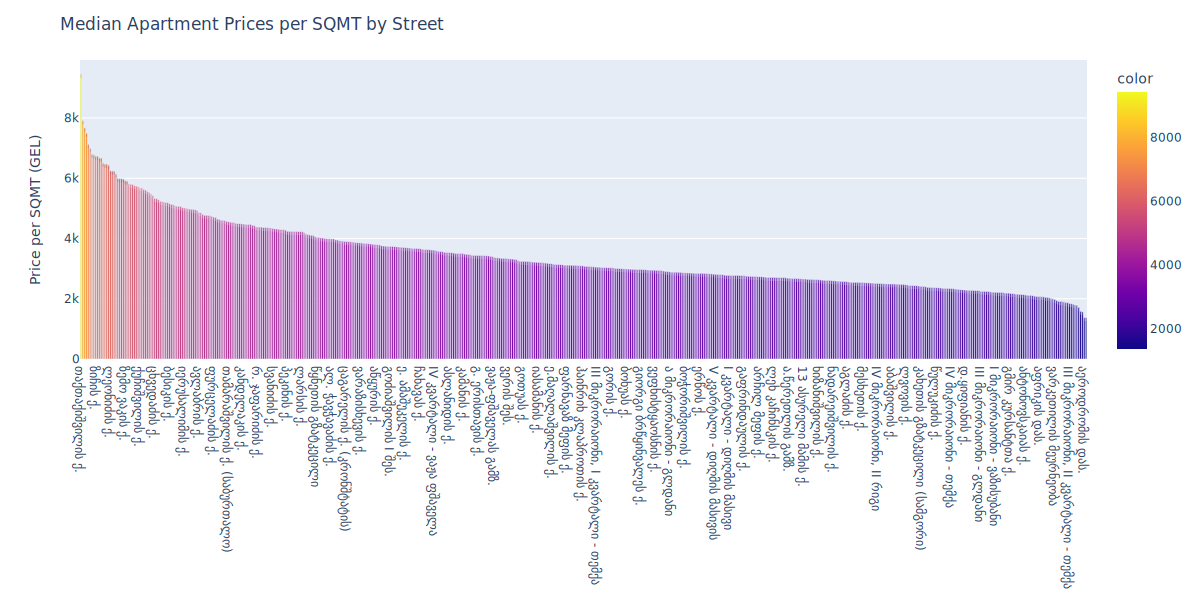

In [21]:
grouped=df.groupby('Suburb').agg({'PriceSQMT (GEL)':['median','count']})\
.sort_values(('PriceSQMT (GEL)','median'),ascending=False)
filt=grouped[grouped[('PriceSQMT (GEL)','count')]>10]

fig=px.bar(x=filt.index,y=filt[('PriceSQMT (GEL)','median')],
       color=filt[('PriceSQMT (GEL)','median')],
       text=filt[('PriceSQMT (GEL)','median')].round())
fig.update_layout(title=dict(text='Median Apartment Prices per SQMT by Suburb',font_family='Arial Black'),height=600,width=1200,hovermode='x unified')
fig.update_yaxes(title='Price per SQMT (GEL)')
fig.update_xaxes(title=None)
fig.show('svg')


grouped=df.groupby('Street').agg({'PriceSQMT (GEL)':['median','count']})\
.sort_values(('PriceSQMT (GEL)','median'),ascending=False)
filt=grouped[grouped[('PriceSQMT (GEL)','count')]>10]

fig=px.bar(x=filt.index,y=filt[('PriceSQMT (GEL)','median')],
       color=filt[('PriceSQMT (GEL)','median')],
       text=filt[('PriceSQMT (GEL)','median')].round())
fig.update_layout(title=dict(text='Median Apartment Prices per SQMT by Street',font_family='Arial Black'),height=600,width=1200,hovermode='x unified')
fig.update_yaxes(title='Price per SQMT (GEL)')
fig.update_xaxes(title=None)
fig.show('svg')